In [51]:
import pyarrow as pa
import pyarrow.parquet as pq

import pandas as pd

import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
from ipywidgets import interact, fixed
import numpy as np

# Actors

In [52]:
actors = pq.read_table("data/actors.parquet")
actors_df = actors.to_pandas()

actors_df

,id,uri,label,jurisdictions,categories
0,bilaxy,bilaxy.com,Bilaxy,HK,exchange
1,banxa,banxa.com,Banxa,"AU, NL, US",exchange
2,aax,www.aax.com,Aax,SC,exchange
3,altcointrader,www.altcointrader.co.za,AltcoinTrader,ZA,exchange
4,azbit,azbit.com,Azbit,MH,exchange
...,...,...,...,...,...
309,stocksexchange,stex.com,Stex,EE,exchange
310,smenarnabitcoin,smenarnabitcoin.cz,Smenarnabitcoin,CZ,exchange
311,xapo,xapo.com,Xapo,US,"exchange, service"
312,yobit,yobit.net,YoBit,RU,exchange


Lets see how the jurisdictions are "distributed"

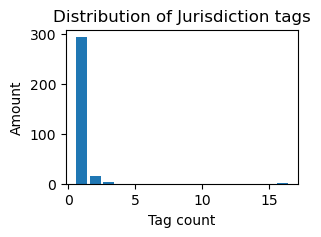

jurisdictions
1     294
2      16
3       3
16      1
Name: count, dtype: int64

In [53]:
# Compute the comma count for each value in the "jurisdictions" column
comma_count_stats = actors_df['jurisdictions'].apply(lambda x: str(x).count(',')+1).value_counts().sort_index()


plt.figure(figsize=(3, 2)) 
plt.bar(comma_count_stats.index, comma_count_stats.values)
plt.xlabel('Tag count')
plt.ylabel('Amount')
plt.title('Distribution of Jurisdiction tags')
plt.show()

comma_count_stats

who has 16 jurisdictions????

In [54]:
actors_df[actors_df['jurisdictions'].str.count(',') == 15]


,id,uri,label,jurisdictions,categories
35,binance,binance.com,"Binance (US, DEX)","AE, AU, BH, CA, CY, ES, FR, IT, KY, KZ, LT, MT...","defi_dex, exchange, mining_service, organization"


In [55]:
actors_df[actors_df['id'].str.contains("binance")== True]

,id,uri,label,jurisdictions,categories
35,binance,binance.com,"Binance (US, DEX)","AE, AU, BH, CA, CY, ES, FR, IT, KY, KZ, LT, MT...","defi_dex, exchange, mining_service, organization"


of course its binance LOL

# Flows

In [56]:
flows = pq.read_table("data/flows.parquet")
flows_df = flows.to_pandas()

flows_df

,src_id,dst_id,value_asset,value_USD,date
0,1coin,1coin,36870000,243.755870,2014-03-03
1,1coin,1coin,380120000,2378.899210,2014-03-10
2,1coin,1coin,429150403,2738.687542,2014-03-13
3,1coin,1coin,333900098,2092.574397,2014-03-14
4,1coin,1coin,779334803,4938.373652,2014-03-15
...,...,...,...,...,...
1939582,zyado,zyado,1019592,11.368847,2017-03-21
1939583,zyado,zyado,1004152,13.325487,2017-04-29
1939584,zyado,zyado,39850720,5966.967603,2018-01-10
1939585,zyado,zyado,19251202,1730.115174,2018-04-27


In which timeframe was the data collected?

In [57]:
# Flow data from - to
print(f'Flow data recorded from {flows_df.date.min()} to {flows_df.date.max()}')

Flow data recorded from 2011-05-13 to 2023-04-12


In [58]:
print(f'Flows before merging actor data {flows_df.shape[0]}')
merged_df = pd.merge(flows_df, actors_df.add_prefix('src_'), on='src_id', how='inner')
merged_df = pd.merge(merged_df, actors_df.add_prefix('dst_'), on='dst_id', how='inner')
print(f'Flows after merging actor data {merged_df.shape[0]}')
display(merged_df.head())

Flows before merging actor data 1939587
Flows after merging actor data 1904481


,src_id,dst_id,value_asset,value_USD,date,src_uri,src_label,src_jurisdictions,src_categories,dst_uri,dst_label,dst_jurisdictions,dst_categories
0,1coin,1coin,36870000,243.755870,2014-03-03,1coin.io,1Coin,"CA, US",exchange,1coin.io,1Coin,"CA, US",exchange
1,1coin,1coin,380120000,2378.899210,2014-03-10,1coin.io,1Coin,"CA, US",exchange,1coin.io,1Coin,"CA, US",exchange
2,1coin,1coin,429150403,2738.687542,2014-03-13,1coin.io,1Coin,"CA, US",exchange,1coin.io,1Coin,"CA, US",exchange
3,1coin,1coin,333900098,2092.574397,2014-03-14,1coin.io,1Coin,"CA, US",exchange,1coin.io,1Coin,"CA, US",exchange
4,1coin,1coin,779334803,4938.373652,2014-03-15,1coin.io,1Coin,"CA, US",exchange,1coin.io,1Coin,"CA, US",exchange


In [59]:
# Types
merged_df['date'] = pd.to_datetime(merged_df['date'])

In [65]:
# Create list for jurisdictions
merged_df = merged_df.assign(src_jurisdictions=merged_df.src_jurisdictions.str.split(','))
merged_df = merged_df.assign(dst_jurisdictions=merged_df.dst_jurisdictions.str.split(','))
# Create year column
merged_df['year'] = merged_df.date.dt.year
# Create separate columns for each jurisdiction (if we want to split the amounts we have to split amount before)
merged_df = merged_df.explode('dst_jurisdictions')
merged_df = merged_df.explode('src_jurisdictions')
# Strip whitespace
merged_df.dst_jurisdictions = merged_df.dst_jurisdictions.str.strip()
merged_df.src_jurisdictions = merged_df.src_jurisdictions.str.strip()
# Remove flows which aren't x-border
merged_df = merged_df[merged_df['dst_jurisdictions'] != merged_df['src_jurisdictions']]
# Grouping
dst_amounts = merged_df.groupby(['year', 'dst_jurisdictions'])['value_USD'].sum().reset_index()
dst_amounts = dst_amounts.rename(columns={"dst_jurisdictions":"jurisdictions"})

src_amounts = merged_df.groupby(['year', 'src_jurisdictions'])['value_USD'].sum().reset_index()
src_amounts = src_amounts.rename(columns={"src_jurisdictions":"jurisdictions"})

display(dst_amounts)
display(src_amounts)

,year,jurisdictions,value_USD
431,2021,US,3.170847e+12
415,2021,MT,2.942987e+12
410,2021,KY,2.942916e+12
435,2021,ZA,2.898482e+12
383,2021,AU,2.894130e+12
...,...,...,...
6,2011,CZ,7.064849e+01
11,2011,SK,7.064849e+01
88,2014,ZA,4.885068e+01
2,2011,BR,2.937990e+01


,year,jurisdictions,value_USD
395,2021,KY,2.989393e+12
400,2021,MT,2.988350e+12
415,2021,US,2.985062e+12
365,2021,AE,2.928324e+12
419,2021,ZA,2.923207e+12
...,...,...,...
125,2016,BR,5.390808e+01
11,2011,SK,5.108329e+01
6,2011,CZ,5.108329e+01
305,2019,TW,4.128866e+01


### How does the general tred look like?

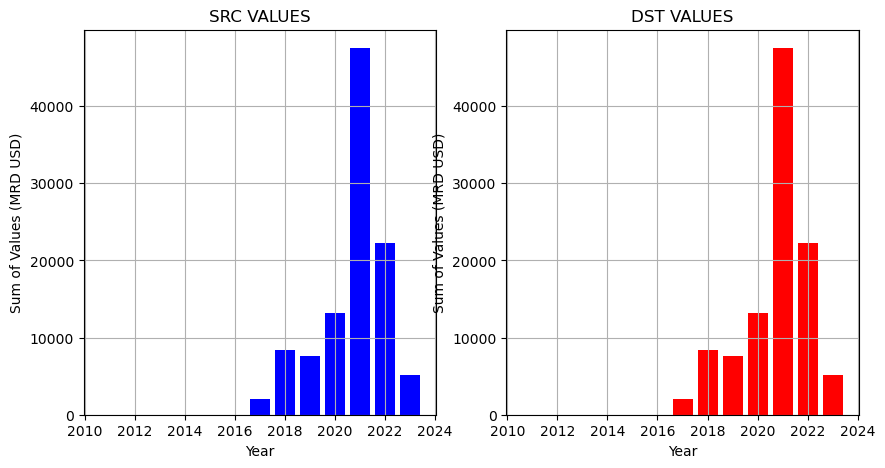

In [79]:
def plot_trend(src_data,dst_data):
    src_grouped = src_data.groupby('year')['value_USD'].sum()/1000000000
    dst_grouped = dst_data.groupby('year')['value_USD'].sum()/1000000000

    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,5))

    ax1.bar(src_grouped.index, src_grouped.values,color="blue")
    ax1.set_xlabel("Year")
    ax1.set_ylabel('Sum of Values (MRD USD)')
    ax1.set_title("SRC VALUES")
    ax1.grid(True)
    ax2.bar(dst_grouped.index, dst_grouped.values,color="red")
    ax2.set_xlabel("Year")
    ax2.set_ylabel('Sum of Values (MRD USD)')
    ax2.set_title("DST VALUES")
    ax2.grid(True)
    plt.show()

plot_trend(src_amounts,dst_amounts)

In [82]:
def plot_juri_bars(data,year,label):
    data = data.sort_values("jurisdictions",ascending=False)
    filtered_data = [d for d in zip(data['year'],data['jurisdictions'], data['value_USD']/1000000000) if d[0] == year]

    #display(filtered_data)
    # Separate the x and y values
    x = [d[1] for d in filtered_data]
    y = [d[2] for d in filtered_data]

    plt.figure(figsize=(10, 5))

    # Plot the bar chart
    plt.bar(x, y)

    # Set labels and title
    plt.xlabel('Jurisdictions')
    plt.ylabel('Value (MRD USD)')
    plt.title(f'{label} in {year}')



    # Rotate x-axis labels for better visibility
    plt.xticks(rotation=90)

    plt.ylim(0,3000)


    # Display the plot
    plt.show()

interact(plot_juri_bars,data=fixed(src_amounts),year=(2012,2022,1),label=fixed("Source values by jurisdictions in"))
interact(plot_juri_bars,data=fixed(dst_amounts),year=(2012,2022,1),label=fixed("Destination values by jurisdictions in"))
#plot_juri_bars(src_amounts,2020,"seife")


interactive(children=(IntSlider(value=2017, description='year', max=2022, min=2012), Output()), _dom_classes=(…

interactive(children=(IntSlider(value=2017, description='year', max=2022, min=2012), Output()), _dom_classes=(…

<function __main__.plot_juri_bars(data, year, label)>

In [20]:
# Load GDP Data

# Load country codes (source: https://github.com/lukes/ISO-3166-Countries-with-Regional-Codes)
country_codes = pd.read_csv('data/country_codes.csv')
display(country_codes.head())

# Load GDP data (PPP) (Source: https://data.worldbank.org/indicator/NY.GDP.PCAP.PP.CD)
gdp = pd.read_csv('data/gdp.csv', skiprows=3)
display(gdp.head())

gdp_meta = pd.read_csv('data/gdp_meta.csv')
display(gdp_meta.head())

,name,alpha-2,alpha-3,country-code,iso_3166-2,region,sub-region,intermediate-region,region-code,sub-region-code,intermediate-region-code
0,Afghanistan,AF,AFG,4,ISO 3166-2:AF,Asia,Southern Asia,NaN,142.0,34.0,NaN
1,Åland Islands,AX,ALA,248,ISO 3166-2:AX,Europe,Northern Europe,NaN,150.0,154.0,NaN
2,Albania,AL,ALB,8,ISO 3166-2:AL,Europe,Southern Europe,NaN,150.0,39.0,NaN
3,Algeria,DZ,DZA,12,ISO 3166-2:DZ,Africa,Northern Africa,NaN,2.0,15.0,NaN
4,American Samoa,AS,ASM,16,ISO 3166-2:AS,Oceania,Polynesia,NaN,9.0,61.0,NaN


,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,Unnamed: 67
0,Aruba,ABW,"GDP per capita, PPP (current international $)",NY.GDP.PCAP.PP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,36846.848285,37343.912963,37583.840323,38865.188195,41679.238190,42501.641554,34971.009913,42698.359872,NaN,NaN
1,Africa Eastern and Southern,AFE,"GDP per capita, PPP (current international $)",NY.GDP.PCAP.PP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,3470.550675,3498.125396,3591.099809,3635.564622,3724.868177,3777.972368,3621.058106,3839.470058,NaN,NaN
2,Afghanistan,AFG,"GDP per capita, PPP (current international $)",NY.GDP.PCAP.PP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,2110.829568,2128.125938,2023.834656,2096.093111,2109.929296,2167.704111,2076.138380,1665.805842,NaN,NaN
3,Africa Western and Central,AFW,"GDP per capita, PPP (current international $)",NY.GDP.PCAP.PP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,4143.177054,4075.994459,3998.951876,4045.303263,4160.540965,4264.731035,4174.504565,4409.450961,NaN,NaN
4,Angola,AGO,"GDP per capita, PPP (current international $)",NY.GDP.PCAP.PP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,8123.048065,7274.090475,7027.146634,7216.061373,7042.923829,6881.076241,6362.636076,6491.125578,NaN,NaN


,Country Code,Region,IncomeGroup,SpecialNotes,TableName,Unnamed: 5
0,ABW,Latin America & Caribbean,High income,NaN,Aruba,NaN
1,AFE,NaN,NaN,"26 countries, stretching from the Red Sea in t...",Africa Eastern and Southern,NaN
2,AFG,South Asia,Low income,The reporting period for national accounts dat...,Afghanistan,NaN
3,AFW,NaN,NaN,"22 countries, stretching from the westernmost ...",Africa Western and Central,NaN
4,AGO,Sub-Saharan Africa,Lower middle income,The World Bank systematically assesses the app...,Angola,NaN


In [21]:
# Merge country codes first
print(f'Dest Rows before merge: {dst_amounts.shape[0]}')
dst = pd.merge(dst_amounts, country_codes[['alpha-2', 'alpha-3', 'region', 'sub-region']], left_on='dst_jurisdictions', right_on='alpha-2', how='left')

print(f'Src rows before merge: {src_amounts.shape[0]}')
src = pd.merge(src_amounts, country_codes[['alpha-2', 'alpha-3', 'region', 'sub-region']], left_on='src_jurisdictions', right_on='alpha-2', how='inner')
#display(src.head())

# Now merge gdp data
dst = pd.merge(dst, gdp, left_on='alpha-3', right_on='Country Code', how='left')
print(f'Dest rows after merge: {dst.shape[0]}')

src = pd.merge(src, gdp, left_on='alpha-3', right_on='Country Code', how='inner')
print(f'Src rows after merge: {src.shape[0]}')

print(display(dst[dst['alpha-3'].isna()]))







Dest Rows before merge: 542
Src rows before merge: 520
Dest rows after merge: 542
Src rows after merge: 510


,year,dst_jurisdictions,value_USD,alpha-2,alpha-3,region,sub-region,Country Name,Country Code,Indicator Name,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,Unnamed: 67


None
